# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [7]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle = True, random_state=1,
                             remove=('headers','footers','quotes'))
documents = dataset.data

print(len(documents))
documents[1]

11314


"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [18]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
  pattern = r'[^a-zA-Z\s]'
  text = re.sub(pattern, '',text)
  return text

def clean_stopword(d):
  stop_words = stopwords.words('english')
  return ' '.join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 3])

def tokenize(d):
  return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
import pandas as pd

news_df = pd.DataFrame({'article':documents})
len(news_df)

11314

In [20]:
news_df.replace("", float("NaN"), inplace=True)
news_df.dropna(inplace=True)
len(news_df)

11096

In [21]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          \nNo arg...
Name: article, Length: 11096, dtype: object

In [22]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased what disagree stat...
1        yeah expect people read actually accept hard a...
2        although realize principle strongest points wo...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system upd...
11313    argument murphy scared hell came last year han...
Name: article, Length: 11096, dtype: object

In [24]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()

In [26]:
import numpy as np

drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = np.delete(tokenized_news, drop_news, axis=0)
print(len(news_texts))

10945


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [32]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_texts[:2000]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(news_2000)

idx2word = {value:key for key, value in tokenizer.word_index.items()}
sequences = tokenizer.texts_to_sequences(news_2000)

In [33]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

29769


In [34]:
print(sequences[1])

[1263, 457, 2, 60, 119, 419, 61, 1374, 22, 69, 3498, 397, 6874, 412, 1173, 373, 2256, 458, 59, 12478, 458, 1900, 3850, 397, 22, 10, 4325, 8749, 177, 303, 136, 154, 664, 12479, 316, 12480, 15, 12481, 4, 790, 12482, 12483, 4917, 8750]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling)

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, 일부 단어만 뽑아서 계산을 하는 방식
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [36]:
from tensorflow.keras.preprocessing.sequence import skipgrams

skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in sequences[:10]]

In [38]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

existance(2744), what(34) -> 1
acts(1308), institues(14181) -> 0
degree(1430), boots(2940) -> 0
letter(663), existance(2744) -> 1
report(627), israels(3496) -> 1


In [40]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
2420
2420


In [41]:
skip_grams = [skipgrams(seq, vocabulary_size=vocab_size, window_size=10) for seq in sequences[:10]]

#### Skipgram 모델 구성

In [44]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [46]:
embed_size = 50

In [51]:
def word2vec():
  target_inputs = Input(shape=(1,), dtype='int32')
  target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

  context_inputs = Input(shape=(1,), dtype='int32')
  context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

  dot_product = Dot(axes=2)([target_embedding, context_embedding])
  dot_product = Reshape((1,), input_shape=(1,1))(dot_product)
  output = Activation('sigmoid')(dot_product)

  model = Model(inputs=[target_inputs,context_inputs], outputs=output)
  model.compile(loss='binary_crossentropy', optimizer='adam')

  return model

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 50)        1488450     ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 50)        1488450     ['input_8[0][0]']                
                                                                                            

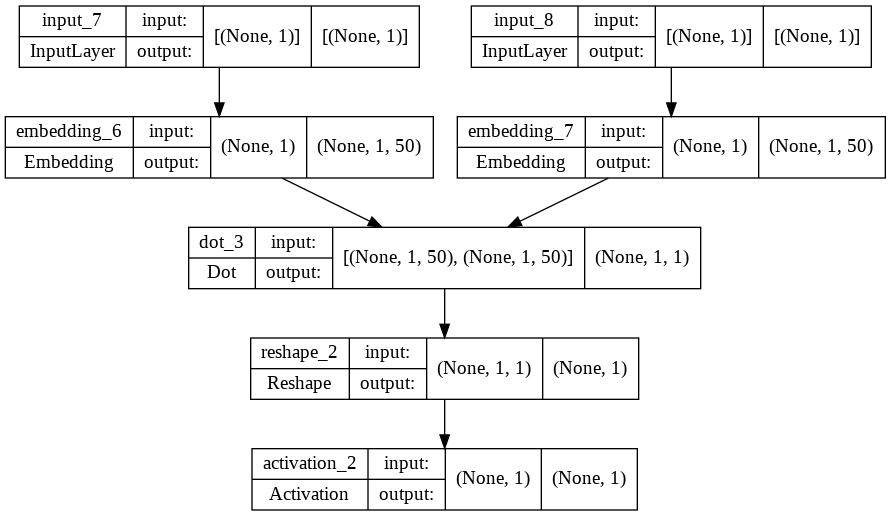

In [53]:
model = word2vec()
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

In [55]:
for epoch in range(1,11):
  loss = 0
  for _, elem in enumerate(skip_grams):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype="int32")
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X,Y)

  print("Epoch :",epoch, "Loss :",loss)

Epoch : 1 Loss : 6.63075053691864
Epoch : 2 Loss : 6.562015056610107
Epoch : 3 Loss : 6.484183132648468
Epoch : 4 Loss : 6.397202968597412
Epoch : 5 Loss : 6.3011637926101685
Epoch : 6 Loss : 6.196289837360382
Epoch : 7 Loss : 6.082927763462067
Epoch : 8 Loss : 5.961535453796387
Epoch : 9 Loss : 5.83266818523407
Epoch : 10 Loss : 5.696966290473938


In [58]:
import gensim

f = open('skipgram.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

skipgram = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt',binary=False)

In [59]:
skipgram.most_similar(positive =['soldiers'])

[('unfortunate', 0.6675860285758972),
 ('away', 0.6101629137992859),
 ('inhuman', 0.5551822185516357),
 ('attending', 0.5527633428573608),
 ('races', 0.5340546369552612),
 ('xmemory', 0.5139235258102417),
 ('after', 0.5086111426353455),
 ('halifax', 0.4989217221736908),
 ('invective', 0.498773992061615),
 ('reports', 0.4909352660179138)]

In [60]:
skipgram.most_similar(positive =['world'])

[('lived', 0.8590950965881348),
 ('media', 0.854651153087616),
 ('described', 0.8030099272727966),
 ('europe', 0.7743369936943054),
 ('having', 0.770418643951416),
 ('proisraeli', 0.7463585138320923),
 ('letter', 0.7343875765800476),
 ('rediculous', 0.7104647159576416),
 ('reputation', 0.7045820355415344),
 ('israels', 0.6851128935813904)]

### CBOW


#### CBOW 전처리

In [66]:
def skipgram2cbow(skipgrams):
  cbows =[]
  flag=0
  for n in skipgrams:
    temp1 = []
    for t in n:
      if flag==1:
        flag=0
        temp1.append(t)
      else:
        flag = 1
        temp2 =[] 
        for x in t:
          temp2.append([x[1], x[0]])
        temp1.append(temp2)
      cbows.append(temp1)

  return cbows

In [67]:
cbows = skipgram2cbow(skipgrams)

In [69]:
pairs, labels = cbows[0][0], cbows[0][1]
for i in range(5):
  print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
      idx2word[pairs[i][0]], pairs[i][0],
      idx2word[pairs[i][1]], pairs[i][1],
      labels[i]))

ignore(1429), seem(173) -> 1
clearly(580), least(114) -> 1
sabine(13038), europe(1638) -> 0
might(41), atrocities(4915) -> 1
msiqncaoushhlnawmrswmvfywm(27201), power(63) -> 0


In [70]:
print(len(cbows))
print(len(pairs))
print(len(labels))

20
2420
2420


#### CBOW 모델 구성

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 50)        1488450     ['input_9[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 50)        1488450     ['input_10[0][0]']               
                                                                                            

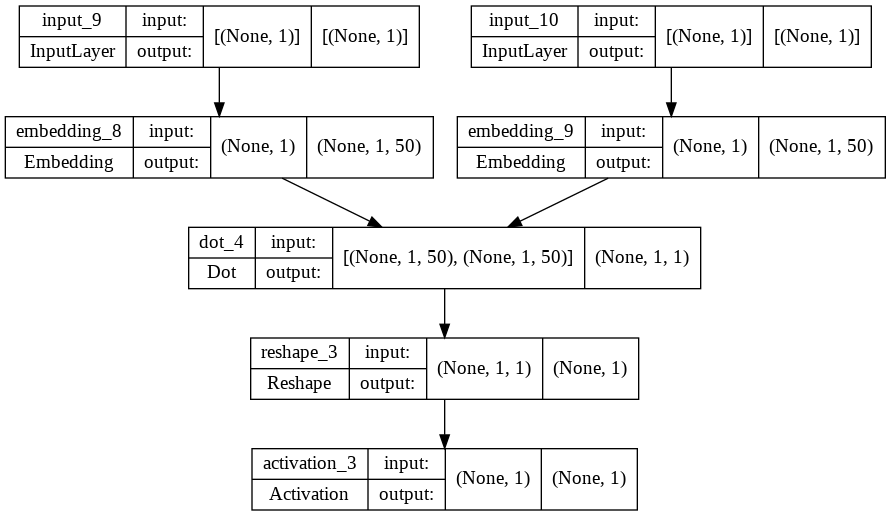

In [71]:
model = word2vec()
model.summary()
plot_model(model,show_shapes=True, show_layer_names=True)

In [73]:
for epoch in range(1,2001):
  loss = 0
  for _, elem in enumerate(cbows):
    first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
    second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
    labels = np.array(elem[1], dtype="int32")
    X = [first_elem, second_elem]
    Y = labels
    loss += model.train_on_batch(X,Y)

  if epoch % 100 ==99:
    print("Epoch :",epoch, "Loss :",loss)

Epoch : 99 Loss : 0.12999258004128933
Epoch : 199 Loss : 0.02981522330082953
Epoch : 299 Loss : 0.017246554663870484
Epoch : 399 Loss : 0.014311952578282217
Epoch : 499 Loss : 0.013399259320067358
Epoch : 599 Loss : 0.013113391629303806
Epoch : 699 Loss : 0.013013073496722427
Epoch : 799 Loss : 0.012962871206809723
Epoch : 899 Loss : 0.01294725162370014
Epoch : 999 Loss : 0.012935132831387364
Epoch : 1099 Loss : 0.012930384526327998
Epoch : 1199 Loss : 0.01292592089663458
Epoch : 1299 Loss : 0.01292329511193202
Epoch : 1399 Loss : 0.012920866470523151
Epoch : 1499 Loss : 0.01291897971356093
Epoch : 1599 Loss : 0.01291728599753128
Epoch : 1699 Loss : 0.012915808880222812
Epoch : 1799 Loss : 0.012914486288735816
Epoch : 1899 Loss : 0.012913273073962728
Epoch : 1999 Loss : 0.012912164943529092


In [74]:
f = open('cbow.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
  f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

cbow = gensim.models.KeyedVectors.load_word2vec_format('cbow.txt',binary=False)

In [75]:
cbow.most_similar(positive=['soldiers'])

[('israeli', 0.9889422655105591),
 ('blessing', 0.9888854026794434),
 ('acts', 0.9514516592025757),
 ('inhuman', 0.9384574890136719),
 ('guilt', 0.9368634223937988),
 ('holocaust', 0.9344001412391663),
 ('away', 0.9267919659614563),
 ('after', 0.9172343015670776),
 ('daily', 0.8979458808898926),
 ('commited', 0.883202850818634)]

In [76]:
cbow.most_similar(positive=['world'])

[('proisraeli', 0.9873902201652527),
 ('lived', 0.9751622080802917),
 ('europe', 0.9695294499397278),
 ('incidences', 0.9666838049888611),
 ('described', 0.9650331735610962),
 ('rediculous', 0.9632833003997803),
 ('letter', 0.9534779787063599),
 ('occured', 0.946255624294281),
 ('reputation', 0.9409463405609131),
 ('seem', 0.8927541375160217)]